# 生成模型进化演示 (GMM → MRF → VAE → GAN → Diffusion)

本 Notebook 演示了从 **传统统计生成模型** 到 **深度生成模型** 的演进过程：
- GMM (高斯混合模型)
- MRF (马尔科夫随机场)
- VAE (变分自编码器)
- GAN (生成对抗网络)
- Diffusion (扩散模型)


## 1. 高斯混合模型 (GMM)

**公式：**
\[
p(x) = \sum_{k=1}^K \pi_k \mathcal{N}(x | \mu_k, \Sigma_k)
\]

- 其中 $\pi_k$ 是混合系数，$\mu_k, \Sigma_k$ 是第 $k$ 个高斯分布的均值和协方差。
- 生成过程：先采样一个 $k$，再从对应的高斯分布中采样一个点。


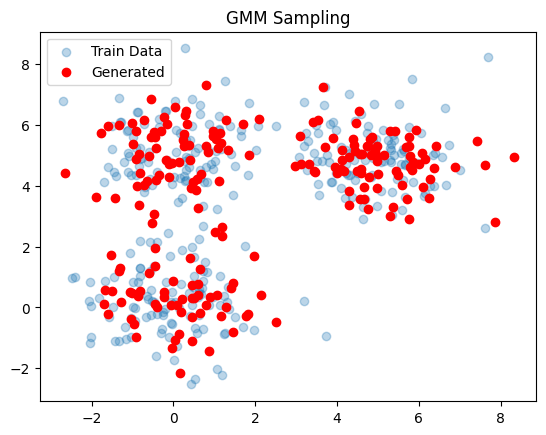

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# 训练数据 (2D)
X = np.vstack([
    np.random.randn(100, 2) + np.array([0, 0]),
    np.random.randn(100, 2) + np.array([5, 5]),
    np.random.randn(100, 2) + np.array([0, 5])
])

# GMM
gmm = GaussianMixture(n_components=3).fit(X)
samples, _ = gmm.sample(200)

# 可视化
plt.scatter(X[:,0], X[:,1], alpha=0.3, label='Train Data')
plt.scatter(samples[:,0], samples[:,1], color='red', label='Generated')
plt.legend(); plt.title('GMM Sampling'); plt.show()

## 2. 马尔科夫随机场 (MRF)

**思想：** 每个像素依赖于邻居像素。

**概率模型：**
\[
p(X) = \frac{1}{Z} \exp\left(- \sum_{(i,j) \in E} V(x_i, x_j) \right)
\]

其中 $V(x_i, x_j)$ 表示相邻像素之间的一致性代价（比如不同就罚分）。

**生成过程：** Gibbs Sampling，从随机图像开始迭代更新像素。

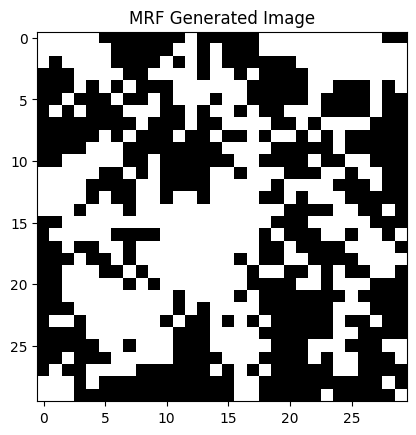

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def gibbs_sampling(size=20, steps=1000):
    img = np.random.choice([0,1], size=(size,size))
    for step in range(steps):
        i, j = np.random.randint(0,size,2)
        neighbors = img[max(i-1,0):min(i+2,size), max(j-1,0):min(j+2,size)].flatten()
        p1 = np.sum(neighbors==1)
        p0 = np.sum(neighbors==0)
        probs = np.array([p0, p1], dtype=float) + 1e-3
        probs = probs / probs.sum()
        img[i,j] = np.random.choice([0,1], p=probs)
    return img


sample = gibbs_sampling(size=30, steps=5000)
plt.imshow(sample, cmap='gray'); plt.title('MRF Generated Image'); plt.show()

## 3. 变分自编码器 (VAE)

**核心公式：** 最大化 ELBO：
\[
\mathcal{L}(\theta, \phi; x) = \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)] - KL(q_\phi(z|x) || p(z))
\]

- Encoder: $q_\phi(z|x)$ → 学习隐变量分布。
- Decoder: $p_\theta(x|z)$ → 从隐变量重建数据。
- 生成：从 $p(z)$ 采样，再用解码器生成。

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, latent_dim)
        self.fc22 = nn.Linear(400, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# 这里只是定义模型，训练需额外写循环，这里省略。

## 4. 生成对抗网络 (GAN)

**目标函数：**
\[
\min_G \max_D \; \mathbb{E}_{x \sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log(1-D(G(z)))]
\]

- 判别器 $D$: 区分真假样本。
- 生成器 $G$: 从噪声 $z$ 生成样本。
- 对抗训练 → 最终 $G$ 生成的样本与真实分布接近。

In [5]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, z_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Tanh()
        )
    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

# 定义结构即可，完整训练需循环。

## 5. 扩散模型 (Diffusion)

**前向过程 (加噪声)：**
\[
q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t}x_{t-1}, \beta_t I)
\]

**反向过程 (去噪声)：** 学习 $p_\theta(x_{t-1}|x_t)$，逐步恢复图像。

**生成：** 从纯噪声 $x_T$ 开始，逐步去噪得到 $x_0$。

这里我们写一个 toy 1D diffusion 示例。

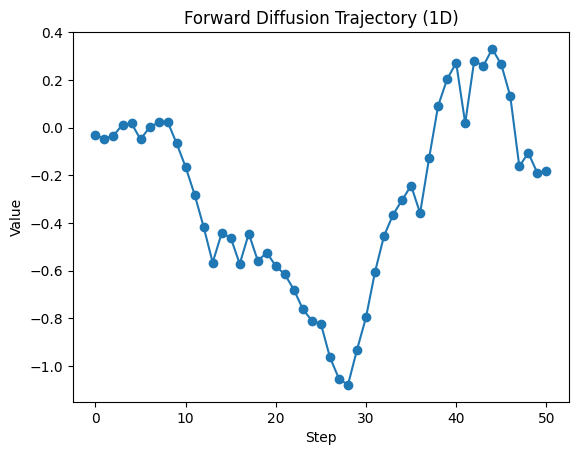

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 数据: 1D 高斯分布
data = np.random.randn(1000)

T = 50
betas = np.linspace(0.001, 0.02, T)
alphas = 1 - betas
alpha_bars = np.cumprod(alphas)

# 前向加噪
x0 = np.random.randn()
xt = x0
path = [x0]
for t in range(T):
    noise = np.sqrt(betas[t]) * np.random.randn()
    xt = np.sqrt(alphas[t]) * xt + noise
    path.append(xt)

plt.plot(path, '-o')
plt.title('Forward Diffusion Trajectory (1D)')
plt.xlabel('Step'); plt.ylabel('Value')
plt.show()

## 总结

- **GMM**: 基于混合分布采样。
- **MRF**: 基于像素局部依赖的采样。
- **VAE**: 基于潜在变量的生成 + 变分推断。
- **GAN**: 基于对抗博弈的生成。
- **Diffusion**: 基于逐步加噪与去噪。